In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '6, 7'

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.utils import make_grid
from glob import glob
import joblib

In [3]:
class MultiClassifier(nn.Module):
    def __init__(self):
        super(MultiClassifier, self).__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3), # 3, 256, 256
            nn.MaxPool2d(2), # op: 16, 127, 127
            nn.ReLU(), # op: 64, 127, 127
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3), # 64, 127, 127   
            nn.MaxPool2d(2), #op: 128, 63, 63
            nn.ReLU() # op: 128, 63, 63
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3), # 128, 63, 63
            nn.MaxPool2d(2), #op: 256, 30, 30
            nn.ReLU() #op: 256, 30, 30
        )
        
        self.Linear1 = nn.Linear(256*14*14, 64)
        self.Linear2 = nn.Linear(64, 2)
                
        
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)

        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.Linear2(x)
        return F.softmax(x)

In [4]:
model = MultiClassifier()

In [5]:
model.load_state_dict(torch.load('./celeba_cls.pth'))

<All keys matched successfully>

In [6]:
model = model.cuda()

In [7]:
# should be changed to the path of generated celeba data

base = '/data/local/qipan/exp_celeba/logs/RANDOM_0116_CELEBA_EXP_EXP10_K256_IMAGE_SIZE_28_BATCH_128_IMPROVED_2/samples' 

In [8]:
images = glob(base + '/image*')

In [9]:
# images

In [10]:
len(images)

60

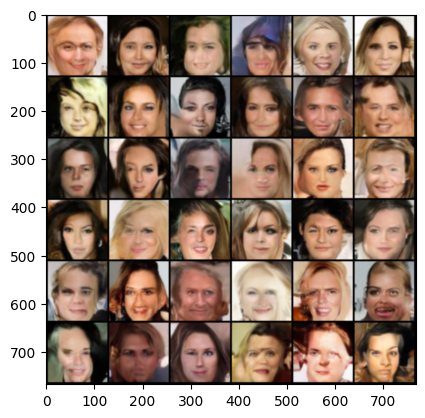

In [11]:
x = Image.open(images[0])

transform=transforms.Compose([
    transforms.Resize((128*6,128*6)),
    transforms.ToTensor()
])

# transform=transforms.Compose([
#     transforms.ToTensor()
# ])

x = transform(x)

plt.imshow(x.permute(1,2,0))

In [12]:
x.shape

torch.Size([3, 768, 768])

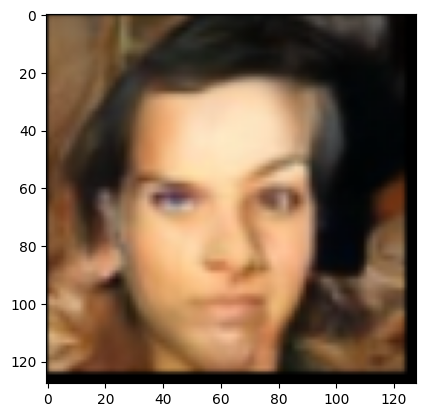

In [14]:
plt.imshow(x[:,128*5:128*6,128*5:128*6].permute(1,2,0))

In [15]:
model(x[:,128*5:128*6,128*5:128*6].unsqueeze(0).cuda())

/tmp/ipykernel_880488/3814926896.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


tensor([[2.1260e-10, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [16]:
train_x = []
train_y = []

In [17]:
from time import time

In [18]:
st = time()

for ix, img in enumerate(images):
    for i in range(6):
        for j in range(6):
            if ix % 100 == 0:
                print(ix, time() - st)
            # split images 6*6 one by one
            x_grid = transform(Image.open(img))
            x = x_grid[:, 128*i:128*(i+1), 128*j:128*(j+1)]
            pred_y = model(x.unsqueeze(0).cuda())
    
            np_x = x.cpu().numpy()
            np_y = torch.round(pred_y).cpu().detach().numpy()[0]
    
            train_x.append(np_x)
            train_y.append(np_y)

    # if ix>10000:
    #     break
    

0 0.00014281272888183594
0 0.1999967098236084


/tmp/ipykernel_880488/3814926896.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


0 0.34615373611450195
0 0.46605467796325684
0 0.6073265075683594
0 0.7276794910430908
0 0.8280766010284424
0 0.9323925971984863
0 1.0434563159942627
0 1.141326904296875
0 1.2149763107299805
0 1.3305580615997314
0 1.449019432067871
0 1.5104405879974365
0 1.6081335544586182
0 1.7008285522460938
0 1.8280284404754639
0 1.9016940593719482
0 1.9989848136901855
0 2.095101833343506
0 2.2009222507476807
0 2.2984986305236816
0 2.3904871940612793
0 2.470632314682007
0 2.570826768875122
0 2.671210527420044
0 2.7791988849639893
0 2.8681771755218506
0 2.967083692550659
0 3.0710489749908447
0 3.192763566970825
0 3.2805752754211426
0 3.3947107791900635
0 3.501615285873413
0 3.58260440826416
0 3.6974968910217285


In [19]:
import numpy as np

In [20]:
yy = [np.argmax(y) for y in train_y]

In [21]:
np.unique(yy, return_counts=True)

(array([0, 1]), array([1468,  692]))

In [22]:
joblib.dump(train_x, './train_celeba_x_exp_fake_2.pkl')
joblib.dump(train_y, './train_celeba_y_exp_fake_2.pkl')

['./train_celeba_y_exp_fake_2.pkl']

In [23]:
len(train_y[0])

2